# Flying insect activity-levels analysis
This notebook demonstrates analysis of flying insect activity levels data from camfi.

First, load the required libraries.

In [1]:
import bz2
import datetime
import gzip
import json

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from scipy.stats import linregress

Next, load the image metadata (including annotations from VIA). It is in a json format with the following structure:

```
{
    "_via_attributes": {
        "file": {
            ...  # Contains default values for image metadata (EXIF) for VIA.
                 # The exact fields may vary with camera model.
        },
        "region": {},
    },
    "_via_img_metadata": {
        "<image_key>" : {
            "file_attributes": {
                ...  # Contains file-specific values for image metadata (EXIF)
            },
            "filename": ...,  # Path to imager file
            "regions": [...],  # List of annotations which have been made in VIA
            "size": -1
        },
    ...
    },
    "_via_settings": {
        ...  #  Contains project settings for VIA.
    }
}
```

Please see the camfi readme for instructions of how to create this file.

The `"_via_img_metadata"` part of the annotation file is the part of interest to us. In particular, we would like to extract the timestamp of the images and the `"regions"` list for each image. Below we load the data and list the names of the available EXIF fields.

In [2]:
# Modify the following line if using different dataset
data_path = "data/cabramurra_all_annotations.json.bz2"

def decompressed_open(filename, mode="r"):
    """
    Convenience wrapper to handle various types of compressed file. Assumes the filename suffix is correct.
    """
    if filename.endswith(".gz"):
        return gzip.open(filename, mode)
    elif filename.endswith(".bz2"):
        return bz2.open(filename, mode)
    else:
        return open(filename, mode)

with decompressed_open(data_path) as json_file:
    annotation = json.load(json_file)
    
image_keys = list(annotation["_via_img_metadata"].keys())

print("The available EXIF fields are:", "-" * 30, *annotation["_via_attributes"]["file"], sep="\n")

The available EXIF fields are:
------------------------------
65535
ApertureValue
ColorSpace
ComponentsConfiguration
CompressedBitsPerPixel
DateTime
DateTimeDigitized
DateTimeOriginal
DigitalZoomRatio
ExifImageHeight
ExifImageWidth
ExifInteroperabilityOffset
ExifOffset
ExifVersion
ExposureBiasValue
ExposureIndex
ExposureMode
ExposureTime
FNumber
FileSource
Flash
FlashPixVersion
FocalLength
FocalPlaneResolutionUnit
FocalPlaneXResolution
FocalPlaneYResolution
GainControl
ISOSpeedRatings
ImageDescription
LightSource
Make
MakerNote
MaxApertureValue
MeteringMode
Model
Orientation
ResolutionUnit
SceneCaptureType
SensingMethod
Software
SubsecTime
UserComment
WhiteBalance
XResolution
YCbCrPositioning
YResolution


With the data loaded, we can then make a summary of the number of annotations per image, as well as extracting the timestamp of the images from the camera's EXIF metadata. We will store this information in a Pandas dataframe.

From the above list of available EXIF metadata fields, we can see that the timestamp field is called `"DateTimeOriginal"`.

Note that a mistake was made when setting up camera 0004. Namely, the timestamps for all images from that camera are one month (31 days) behind. We will fix that now.

In [3]:
img_dates, filenames, n_annotations = [], [], []

for i, img_key in enumerate(image_keys):
    filename = annotation["_via_img_metadata"][img_key]["filename"]
    datetime_to_append = pd.to_datetime(
        annotation["_via_img_metadata"][img_key]["file_attributes"]["DateTimeOriginal"], format="%Y:%m:%d %H:%M:%S"
    )
    
    # Fixing incorrect timestamps. Comment the following two lines if using a different dataset:
    if "/0004/" in filename:
        datetime_to_append += pd.to_timedelta(31, "D")
        
    img_dates.append(datetime_to_append)
    filenames.append(filename)
    n_annotations.append(len(annotation["_via_img_metadata"][img_key]["regions"]))    
    
df = pd.DataFrame(
    data=dict(
        timestamp=img_dates,
        filename=filenames,
        n_annotations=n_annotations,
    ),
)
df.set_index("timestamp", drop=False, inplace=True)

df.sort_index(inplace=True)

print(f"Total annotations: {df['n_annotations'].sum()}")

df

Total annotations: 1419


,timestamp,filename,n_annotations
timestamp,,,
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0001/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0004/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0003/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0007/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0009/DSCF0001.JPG,0
...,...,...,...
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0008/DSCF0864.JPG,0
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0007/DSCF0864.JPG,0
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0001/DSCF0864.JPG,0


To get a general overview of the activity levels observed throughout the study period, we pool the data from all cameras and plot the number of annotations per 10-minute interval:

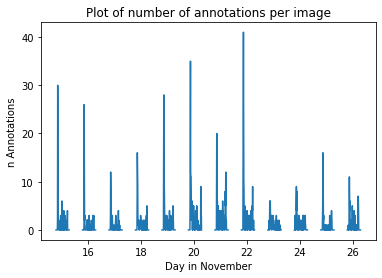

In [4]:
df["novemberday"] = df["timestamp"].dt.day.values + \
                    df["timestamp"].dt.hour.values / 24 + \
                    df["timestamp"].dt.minute.values / 1440

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Plot of number of annotations per image",
    ylabel="n Annotations",
    xlabel="Day in November"
)

h, bx, by = np.histogram2d(
    df["novemberday"],
    df["n_annotations"],
    bins = [
        np.arange(min(df["novemberday"]) - 1 / 288, max(df["novemberday"]) + 1 / 288, 1 / 144),
        np.arange(-0.5, max(df["n_annotations"]) + 1, 1)
    ]
)

b_midpoints = (bx[:-1] + bx[1:]) / 2

n_annotations_per10min = (h * np.arange(h.shape[1]).reshape((1, h.shape[1]))).sum(axis=1)
n_annotations_per10min[h.sum(axis=1) == 0.] = np.nan

p = ax.plot(b_midpoints, n_annotations_per10min)

The gaps in the above figure are periods where the cameras were not set to take photos (they were only set to take photos between the hours of 19:00-07:00 AEDT each night).

There seems to be a periodic signal in the data, with more activity in the evening. We can take a closer look at this by pooling the data from all days into a single representative 24-hour period.

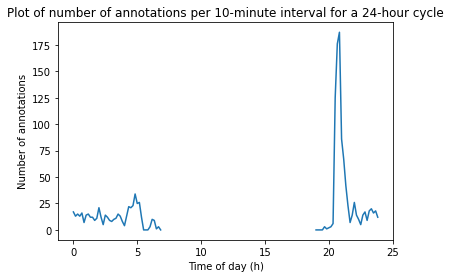

In [5]:
df["daytime"] = datetime.datetime(1680, 1, 1) + (df["timestamp"] - pd.to_datetime(df["timestamp"].dt.date))
df["dayhour"] = df["daytime"].dt.hour.values + df["daytime"].dt.minute.values / 60

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Plot of number of annotations per 10-minute interval for a 24-hour cycle",
    ylabel="Number of annotations",
    xlabel="Time of day (h)"
)

h24, bx24, by24 = np.histogram2d(
    df["dayhour"],
    df["n_annotations"],
    bins = [
        np.arange(-1 / 12, 24 + 1 / 6, 1 / 6),
        np.arange(-0.5, max(df["n_annotations"]) + 1, 1)
    ]
)

b24_midpoints = (bx24[:-1] + bx24[1:]) / 2

n_annotations_per10min24 = (h24 * np.arange(h24.shape[1]).reshape((1, h24.shape[1]))).sum(axis=1)
n_annotations_per10min24[h24.sum(axis=1) == 0.] = np.nan

p = ax.plot(b24_midpoints, n_annotations_per10min24)

In the above figure we see a striking increase in activity levels during the hours of 20:20-21:20. This seems to be when the most insects are flying.

Taking the mean number of annotations per image during this period for each day, we can then look at how activity levels were across the days of the study period. Next, we merge these daily activity levels with daily temperature data from the Bureau of Meterology.

In [6]:
# Summarising evening activity across each study day
df_maelstrom = df[
    (df.daytime >= datetime.datetime(1680, 1, 1, 20, 20)) & (df.daytime < datetime.datetime(1680, 1, 1, 21, 20))
]
maelstrom_intensity = df_maelstrom.groupby(df_maelstrom["timestamp"].dt.date)["n_annotations"].mean()
maelstrom_intensity = pd.DataFrame(maelstrom_intensity)
maelstrom_intensity["date"] = pd.to_datetime(maelstrom_intensity.index)

# Loading weather data
weather_data_path = "data/cabramurra_bom_weather_201911.csv"
weather_df = pd.read_csv(weather_data_path, skiprows=6, header=0)
weather_df["Date"] = pd.to_datetime(weather_df["Date"])

# Database merge of evening activity and daily weather data
maelstrom_weather = maelstrom_intensity.merge(
    weather_df,
    how="left",
    left_on="date",
    right_on="Date",
)
maelstrom_weather

,n_annotations,date,Date,Minimum temperature (C),Maximum temperature (C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1.300000,2019-11-14,2019-11-14,-0.6,12.3,0.0,NaN,NaN,W,41,...,3.0,W,17,NaN,10.1,73,NaN,W,22,NaN
1,0.700000,2019-11-15,2019-11-15,4.7,13.8,0.0,NaN,NaN,WNW,70,...,2.0,WNW,31,NaN,12.8,53,NaN,WNW,31,NaN
2,0.583333,2019-11-16,2019-11-16,3.7,14.3,0.0,NaN,NaN,WNW,48,...,NaN,WNW,11,NaN,13.2,35,NaN,W,20,NaN
3,0.800000,2019-11-17,2019-11-17,3.3,14.3,0.0,NaN,NaN,WNW,33,...,0.0,NE,7,NaN,13.4,26,NaN,WNW,13,NaN
4,1.216667,2019-11-18,2019-11-18,4.5,16.0,0.0,NaN,NaN,WNW,43,...,2.0,W,15,NaN,14.5,35,NaN,WNW,24,NaN
5,1.433333,2019-11-19,2019-11-19,7.5,21.7,0.0,NaN,NaN,WNW,65,...,0.0,WNW,30,NaN,20.6,22,NaN,WNW,30,NaN
6,0.916667,2019-11-20,2019-11-20,11.0,23.1,0.0,NaN,NaN,WNW,31,...,1.0,NNW,7,NaN,21.3,23,NaN,WNW,17,NaN
7,1.800000,2019-11-21,2019-11-21,15.0,27.6,0.0,NaN,NaN,NNW,50,...,1.0,NNE,13,NaN,27.3,22,NaN,NNW,22,NaN
8,0.366667,2019-11-22,2019-11-22,17.2,22.6,0.0,NaN,NaN,NNW,54,...,1.0,WNW,15,NaN,21.7,39,NaN,W,26,NaN
9,0.550000,2019-11-23,2019-11-23,11.3,20.0,0.0,NaN,NaN,WNW,43,...,0.0,W,15,NaN,18.5,28,NaN,W,22,NaN


Now we can plot these data:

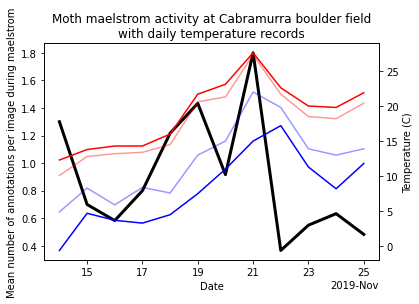

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(
    111,
    title="Moth maelstrom activity at Cabramurra boulder field\nwith daily temperature records",
    ylabel="Mean number of annotations per image during maelstrom",
    xlabel="Date",
)
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (C)")

# Plotting insect evening activity levels
ax1.plot(
    maelstrom_weather["date"],
    maelstrom_weather["n_annotations"],
    c="k",
    lw=3,
    label="Bogong moth maelstrom activity",
)

# Plotting daily temperature data
ax2.plot(
    maelstrom_weather["date"],
    maelstrom_weather["Maximum temperature (C)"],
    c="r",
    label="Maximum temperature (C)",
)
ax2.plot(
    maelstrom_weather["date"],
    maelstrom_weather["3pm Temperature (C)"],
    c="r",
    alpha=0.4,
    label="3pm Temperature (C)",
)
ax2.plot(
    maelstrom_weather["date"],
    maelstrom_weather["Minimum temperature (C)"],
    c="b",
    label="Minimum temperature (C)",
)
ax2.plot(
    maelstrom_weather["date"],
    maelstrom_weather["9am Temperature (C)"],
    c="b",
    alpha=0.4,
    label="9am Temperature (C)",
)

# Correctly formatting axes
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

Finally, we can combine the above plots into a single figure from the publication:

In [ ]:
fig = plt.figure(
    figsize=(7.5, 5.2),
    #dpi=1000.0,
    tight_layout=True,
)
title_y = 0.88

ax1 = fig.add_subplot(
    221,
    xlabel="Date",
    ylabel="Number of annotations",
)
ax1.set_title(" a.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax1.plot(b_midpoints, n_annotations_per10min, c="k", lw=0.75)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2 = fig.add_subplot(
    222,
    xlabel="Time of day (h)",
)
ax2.set_title(" b.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax2.plot(b24_midpoints, n_annotations_per10min24, c="k", lw=0.75)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax3 = fig.add_subplot(
    212,
    xlabel="Date",
    ylabel="Mean number of\nannotations per image",    
)
ax3.set_title(" c.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax3.plot(
    maelstrom_weather["date"],
    maelstrom_weather["n_annotations"],
    c="k",
    label="Bogong moth maelstrom activity",
)

ax4 = ax3.twinx()
ax4.set_ylabel("Temperature (°C)")
ax4.plot(
    maelstrom_weather["date"],
    maelstrom_weather["Maximum temperature (C)"],
    c="r",
    alpha=0.7,
    label="Maximum temperature (C)",
)
ax4.plot(
    maelstrom_weather["date"],
    maelstrom_weather["3pm Temperature (C)"],
    c="r",
    alpha=0.2,
    label="3pm Temperature (C)",
)
ax4.plot(
    maelstrom_weather["date"],
    maelstrom_weather["Minimum temperature (C)"],
    c="b",
    alpha=0.7,
    label="Minimum temperature (C)",
)
ax4.plot(
    maelstrom_weather["date"],
    maelstrom_weather["9am Temperature (C)"],
    c="b",
    alpha=0.2,
    label="9am Temperature (C)",
)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

We then may like to regress the activity levels against various factors. Here, we regress against maximum daily temperature:

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Maelstrom activity vs. Maximum temperature",
    ylabel="Maelstrom activity (mean annotations per image)",
    xlabel="Maximum temperature (°C)",
)

ax.scatter(maelstrom_weather["Maximum temperature (C)"], maelstrom_weather["n_annotations"], marker="x", c="k")

m, c, rvalue, pvalue, m_stderr = linregress(maelstrom_weather["Maximum temperature (C)"], maelstrom_weather["n_annotations"])

extremes = np.array([min(maelstrom_weather["Maximum temperature (C)"]), max(maelstrom_weather["Maximum temperature (C)"])])
ax.plot(
    extremes,
    extremes * m + c,
    c="k"
)

print(f"Intercept: {c} px\tGradient: {m} /s")
print(f"R**2 = {rvalue ** 2}")
print(f"p-value = {pvalue}")